In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
import tensorflow as tf

In [2]:
vidpath = '../data/cat.mp4'

In [3]:
# prompt: load a single frame of a video file

def load_single_frame(video_path, frame_number):
  """Loads a single frame from a video file.

  Args:
    video_path: Path to the video file.
    frame_number: The frame number to load (0-indexed).

  Returns:
    A NumPy array representing the frame, or None if the frame
    number is invalid or the file cannot be opened.
  """
  try:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      print(f"Error opening video file: {video_path}")
      return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if not 0 <= frame_number < total_frames:
      print(f"Invalid frame number: {frame_number}. Total frames: {total_frames}")
      return None

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print(f"Error reading frame {frame_number}")
        return None
  except Exception as e:
    print(f"An error occurred: {e}")
    return None


Click in the window to select TOP‑LEFT, TOP‑RIGHT, BOTTOM‑RIGHT, BOTTOM‑LEFT (in that order).
Selected corners (row, col):
[[  87  328]
 [ 100 1517]
 [1042 1508]
 [1055  336]]


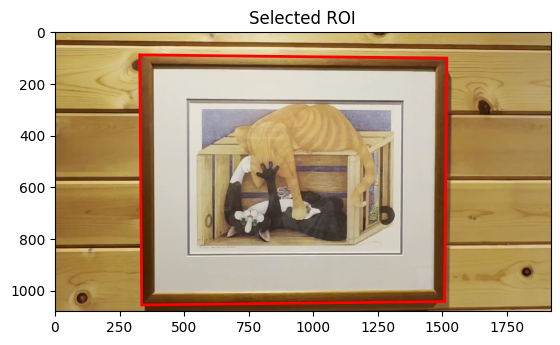

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


frame0 = load_single_frame(vidpath, 0)   

# interactive picking
points = []
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        points.append((x, y))
        # draw a small circle 
        cv2.circle(frame_disp, (x, y), 5, (0, 255, 0), -1)

# Convert to BGR uint8 for cv2 display
frame_disp = cv2.cvtColor((frame0 ).astype('uint8'), cv2.COLOR_RGB2BGR)
win = "Select 4 corners: TL → TR → BR → BL"
cv2.namedWindow(win)
cv2.setMouseCallback(win, mouse_callback)

print("Click in the window to select TOP‑LEFT, TOP‑RIGHT, BOTTOM‑RIGHT, BOTTOM‑LEFT (in that order).")

# Show window and wait until 4 clicks
while True:
    cv2.imshow(win, frame_disp)
    if len(points) == 4:
        break
    # small delay 
    if cv2.waitKey(50) & 0xFF == 27:  # Esc to abort early
        break

cv2.destroyAllWindows()

# Convert collected (x,y) to (row, col) array
corners = np.array([[y, x] for (x, y) in points])  # shape (4,2)

print("Selected corners (row, col):")
print(corners)

# width = horizontal span (x‑axis = column index)
width  = int(max(abs(corners[1,1] - corners[0,1]),   # top edge
                 abs(corners[2,1] - corners[3,1])))  # bottom edge

# height = vertical span (y‑axis = row index)
height = int(max(abs(corners[3,0] - corners[0,0]),   # left edge
                 abs(corners[2,0] - corners[1,0])))  # right edge

rectcorners = np.array([[0, 0],
                        [0, width],
                        [height, width],
                        [height, 0]])


H0C, _ = cv2.findHomography(corners[:, ::-1],   # col,row order
                            rectcorners[:, ::-1],
                            cv2.RANSAC)

# visualize the region picked
plt.imshow(frame0)
plt.fill(corners[:,1], corners[:,0],
         edgecolor='red', lw=2, facecolor='none')
plt.title("Selected ROI")
plt.show()


In [6]:
# Rectify Original Image
def rectify(img, incorners, outcorners):
  outsize = (outcorners[2, 1], outcorners[2, 0])
  H, m = cv2.findHomography(incorners[:,::-1], outcorners[:,::-1], cv2.RANSAC) # uses col,row order
  outimg = cv2.warpPerspective(img, H, outsize)
  return outimg


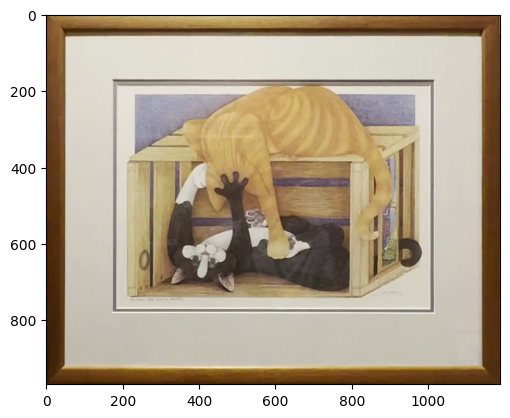

In [7]:
# show original rectified image
refimg = rectify(frame0, corners, rectcorners)
plt.imshow(refimg)
plt.show()

In [8]:
def find_homography(img0, img1):
  gray0 = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
  gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

  orb = cv2.ORB_create()
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  kp0, des0 = orb.detectAndCompute(gray0, None)
  kp1, des1 = orb.detectAndCompute(gray1, None)

  matches = bf.match(des0, des1)
  matches = sorted(matches, key = lambda x:x.distance)

  src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  des_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

  H, m = cv2.findHomography(src_pts, des_pts, cv2.RANSAC, 5.0)

  return H

In [9]:
frame0 = load_single_frame(vidpath, 0)
ref_patch = rectify(frame0, corners, rectcorners)

# resize to 128×128 and pad to 192×192
patch_128  = cv2.resize(ref_patch, (128,128), interpolation=cv2.INTER_LINEAR)
patch_192  = tf.image.pad_to_bounding_box(
                tf.expand_dims(patch_128,0), 32, 32, 192, 192
             )[0].numpy()

# prepare uint8 RGB inputs for ORB
tmpl_u8  = (patch_192 * 255).astype(np.uint8)
frame0_u8 = (cv2.resize(frame0, (192,192)) * 255).astype(np.uint8)

# find the patch→frame0 mapping
H_orb_init = find_homography(frame0_u8, tmpl_u8).astype(np.float32)
# batch it and cast to tf.float32
H_orb_tf   = tf.expand_dims(tf.convert_to_tensor(H_orb_init), 0)  # (1,3,3)

2025-07-24 09:52:22.452513: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-07-24 09:52:22.452535: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-07-24 09:52:22.452544: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-07-24 09:52:22.452579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-24 09:52:22.452595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
import sys
sys.path.append('../')
from data_read import *
from net import *
import matplotlib.pyplot as plt
import numpy as np

import argparse

import os

parser = argparse.ArgumentParser()


parser.add_argument('--dataset_name', action="store", dest= "dataset_name",default="MSCOCO",help='MSCOCO,GoogleMap,GoogleEarth,DayNight')


parser.add_argument('--epoch_load_one', action="store", dest="epoch_load_one", type=int, default=3,help='epoch_load_one')


parser.add_argument('--epoch_load_two', action="store", dest="epoch_load_two", type=int, default=3,help='epoch_load_two')

parser.add_argument('--epoch_load_three', action="store", dest="epoch_load_three", type=int, default=3,help='epoch_load_three')

parser.add_argument('--num_iters', action="store", dest="num_iters", type=int, default=20,help='num_iters')

parser.add_argument('--feature_map_type', action="store", dest="feature_map_type", default='special',help='regular or special')

parser.add_argument('--initial_type', action="store", dest="initial_type", default='multi_net',help='vanilla, simple_net, multi_net')

parser.add_argument('--load_epoch_simplenet', action="store", dest="load_epoch_simplenet", default=50,help='load_epoch_simplenet')

parser.add_argument('--load_epoch_multinet', action="store", dest="load_epoch_multinet", default=[50,50,40],help='load_epoch_multinet')


input_parameters = parser.parse_args([])



gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)



def construct_matrix_regression(batch_size,network_output,network_output_2=[0]):
    extra=tf.ones((batch_size,1))
    predicted_matrix=tf.concat([network_output,extra],axis=-1)
    predicted_matrix=tf.reshape(predicted_matrix,[batch_size,3,3])
    if len(np.shape(network_output_2))>1:
        predicted_matrix_2=tf.concat([network_output_2,extra],axis=-1)
        predicted_matrix_2=tf.reshape(predicted_matrix_2,[batch_size,3,3])
    hh_matrix=[]
    for i in range(batch_size):
        if len(np.shape(network_output_2))>1:
            hh_matrix.append(np.linalg.inv(np.dot(predicted_matrix_2[i,:,:],predicted_matrix[i,:,:])))
        else:
            hh_matrix.append(np.linalg.inv(predicted_matrix[i,:,:]))
        #hh_matrix.append(predicted_matrix[i,:,:])
    
    #return tf.linalg.inv(predicted_matrix+0.0001)
    return np.asarray(hh_matrix)

def initial_motion_COCO():
    # prepare source and target four points
    matrix_list=[]
    for i in range(1):
       
        src_points=[[0,0],[127,0],[127,127],[0,127]]

        tgt_points=[[32,32],[160,32],[160,160],[32,160]]

    
        src_points=np.reshape(src_points,[4,1,2])
        tgt_points=np.reshape(tgt_points,[4,1,2])

        # find homography
        h_matrix, status = cv2.findHomography(src_points, tgt_points,0)
        matrix_list.append(h_matrix)
    return np.asarray(matrix_list).astype(np.float32)


def construct_matrix(initial_matrix,scale_factor,batch_size):
    #scale_factor size_now/(size to get matrix)
    initial_matrix=tf.cast(initial_matrix,dtype=tf.float32)
    
    scale_matrix=np.eye(3)*scale_factor
    scale_matrix[2,2]=1.0
    scale_matrix=tf.cast(scale_matrix,dtype=tf.float32)
    scale_matrix_inverse=tf.linalg.inv(scale_matrix)

    scale_matrix=tf.expand_dims(scale_matrix,axis=0)
    scale_matrix=tf.tile(scale_matrix,[batch_size,1,1])

    scale_matrix_inverse=tf.expand_dims(scale_matrix_inverse,axis=0)
    scale_matrix_inverse=tf.tile(scale_matrix_inverse,[batch_size,1,1])

    final_matrix=tf.matmul(tf.matmul(scale_matrix,initial_matrix),scale_matrix_inverse)
    return final_matrix



def average_cornner_error(batch_size,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127):
    
    four_conner=[[top_left_u,top_left_v,1],[bottom_right_u,top_left_v,1],[bottom_right_u,bottom_right_v,1],[top_left_u,bottom_right_v,1]]
    four_conner=np.asarray(four_conner)
    four_conner=np.transpose(four_conner)
    four_conner=np.expand_dims(four_conner,axis=0)
    four_conner=np.tile(four_conner,[batch_size,1,1]).astype(np.float32)
    
    new_four_points=tf.matmul(predicted_matrix,four_conner)
    
    new_four_points_scale=new_four_points[:,2:,:]
    new_four_points= new_four_points/new_four_points_scale
    
    
    u_predict=new_four_points[:,0,:]
    v_predict=new_four_points[:,1,:]
    
    average_conner=tf.reduce_mean(tf.sqrt(tf.math.pow(u_predict-u_list,2)+tf.math.pow(v_predict-v_list,2)))

    return average_conner
    

def calculate_feature_map(input_tensor):
    bs,height,width,channel=tf.shape(input_tensor)
    path_extracted=tf.image.extract_patches(input_tensor, sizes=(1,3,3,1), strides=(1,1,1,1), rates=(1,1,1,1), padding='SAME')
    path_extracted=tf.reshape(path_extracted,(bs,height,width,channel,9))
    path_extracted_mean=tf.math.reduce_mean(path_extracted,axis=3,keepdims=True)

    #path_extracted_mean=tf.tile(path_extracted_mean,[1,1,1,channel,1])
    path_extracted=path_extracted-path_extracted_mean
    path_extracted_transpose=tf.transpose(path_extracted,(0,1,2,4,3))
    variance_matrix=tf.matmul(path_extracted_transpose,path_extracted)
    
    tracevalue=tf.linalg.trace(variance_matrix)
    row_sum=tf.reduce_sum(variance_matrix,axis=-1)
    max_row_sum=tf.math.reduce_max(row_sum,axis=-1)
    min_row_sum=tf.math.reduce_min(row_sum,axis=-1)
    mimic_ratio=(max_row_sum+min_row_sum)/2.0/tracevalue
    
    return  tf.expand_dims(mimic_ratio,axis=-1)


if input_parameters.feature_map_type=='special':

    load_path_one='../checkpoints/'+input_parameters.dataset_name+'/level_one/'

    load_path_two='../checkpoints/'+input_parameters.dataset_name+'/level_two/'

    load_path_three='../checkpoints/'+input_parameters.dataset_name+'/level_three/'

    level_one_input=ResNet_first_input()
    level_one_template=ResNet_first_template()
    level_two_input=ResNet_second_input()
    level_two_template=ResNet_second_template()
    level_three_input=ResNet_third_input()
    level_three_template=ResNet_third_template()


level_one_input.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"input_full")

level_one_template.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"template_full")

level_two_input.load_weights(load_path_two + 'epoch_'+str(input_parameters.epoch_load_two)+"input_full")

level_two_template.load_weights(load_path_two  + 'epoch_'+str(input_parameters.epoch_load_two)+"template_full")

level_three_input.load_weights(load_path_three + 'epoch_'+str(input_parameters.epoch_load_three)+"input_full")

level_three_template.load_weights(load_path_three  + 'epoch_'+str(input_parameters.epoch_load_three)+"template_full")


if input_parameters.initial_type=='multi_net':
    save_path_one='../checkpoints/'+input_parameters.dataset_name+'/regression_stage_1/'
    save_path_two='../checkpoints/'+input_parameters.dataset_name+'/regression_stage_2/'
    save_path_three='../checkpoints/'+input_parameters.dataset_name+'/regression_stage_3/'
    regression_network_one=Net_first()
    regression_network_one.load_weights(save_path_one + 'epoch_'+str(input_parameters.load_epoch_multinet[0]))
    regression_network_two=Net_second()
    regression_network_two.load_weights(save_path_two + 'epoch_'+str(input_parameters.load_epoch_multinet[1]))
    regression_network_three=Net_third()
    regression_network_three.load_weights(save_path_three + 'epoch_'+str(input_parameters.load_epoch_multinet[2]))
    

LK_layer_one=Lucas_Kanade_layer(batch_size=1,height_template=128,width_template=128,num_channels=1)

LK_layer_two=Lucas_Kanade_layer(batch_size=1,height_template=64,width_template=64,num_channels=1)

LK_layer_three=Lucas_Kanade_layer(batch_size=1,height_template=32,width_template=32,num_channels=1)


LK_layer_regression=Lucas_Kanade_layer(batch_size=1,height_template=192,width_template=192,num_channels=3)
    

Virtual devices cannot be modified after being initialized


In [11]:
VIDEO_PATH = '../data/cat.mp4'
OUT_DIR    = 'cat_warped'
os.makedirs(OUT_DIR, exist_ok=True)

#  Open video and grab the very first frame as TEMPLATE
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError(f"Cannot open video “{VIDEO_PATH}”")

ok, frame0_bgr = cap.read()
if not ok:
    raise RuntimeError("Failed to read the first frame.")

template_rgb = cv2.cvtColor(frame0_bgr, cv2.COLOR_BGR2RGB) / 255.0
# template_rgb = refimg / 255.0
if template_rgb.ndim == 2:                             # safety for grayscale
    template_rgb = template_rgb[..., None].repeat(3, -1)

# ── resize & tensorise exactly like the single‑image version ─────────
target_input_dim    = (192, 192)
target_template_dim = (128, 128)
template_resized = cv2.resize(template_rgb, target_template_dim,
                              interpolation=cv2.INTER_LINEAR)
template_img = tf.expand_dims(tf.convert_to_tensor(template_resized,
                                                   tf.float32), 0)

u_list = np.array([[0, target_template_dim[0]-1,
                    target_template_dim[0]-1, 0]], dtype=np.float32)
v_list = np.array([[0, 0,
                    target_template_dim[1]-1, target_template_dim[1]-1]],
                  dtype=np.float32)

#prev_global_H_128 = np.eye(3, dtype=np.float32) 

frame_idx = 0         
while True:
    ok, frame_bgr = cap.read()
    if not ok:
        break        

    frame_idx += 1
    print(f"── Frame {frame_idx}")

    input_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB) / 255.0
    # if input_rgb.ndim == 2:
    #     input_rgb = input_rgb[..., None].repeat(3, -1)

    input_resized = cv2.resize(input_rgb, target_input_dim,
                               interpolation=cv2.INTER_LINEAR)
    
    # # pre‑warp the current frame with last frame’s homography 
    # input_img_resized = cv2.warpPerspective(
    #     input_resized,          # <-- 192 × 192 RGB float32 in [0,1]
    #     prev_global_H_192,          # <-- H_template→frame_{k‑1}  (192‑px coords)
    #     (192, 192),
    #     flags=cv2.INTER_LINEAR
    # )
    input_img = tf.expand_dims(tf.convert_to_tensor(input_resized,
                                                    tf.float32), 0)

    iters = frame_idx - 1        
    total_error=0.0    

    fk_loop=input_parameters.num_iters
    # prev_H_32 = construct_matrix(prev_global_H_128,
    #                          scale_factor=0.25,   # 128 → 32
    #                          batch_size=1)
    # print(f"Before {frame_idx}: prev_H_32 is {prev_H_32}")  
    if input_parameters.initial_type=='multi_net':
        input_img_grey=tf.image.rgb_to_grayscale(input_img)
        template_img_new=tf.image.pad_to_bounding_box(template_img, 32, 32, 192, 192)  
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_one=regression_network_one.call(network_input,training=False)
        matrix_one=construct_matrix_regression(1,homography_vector_one)
        template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_one)
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new) 
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_two=regression_network_two.call(network_input,training=False)
        matrix_two=construct_matrix_regression(1,homography_vector_one,homography_vector_two)
        template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_two)
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)  
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_three=regression_network_three.call(network_input,training=False)

        extra=tf.ones((1,1))
        initial_matrix=tf.concat([homography_vector_three,extra],axis=-1)
        initial_matrix=tf.reshape(initial_matrix,[1,3,3])
        initial_matrix=np.dot(initial_matrix[0,:,:], np.linalg.inv(matrix_two[0,:,:]))
        initial_matrix=np.expand_dims(initial_matrix,axis=0)
        initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)
        # initial_matrix = initial_matrix @ prev_H_32 
        # print(f"Ending {frame_idx}: prev_H_32 is {initial_matrix}") 


        
    input_feature_one=level_one_input.call(input_img,training=False)
    template_feature_one=level_one_template.call(template_img,training=False)

    input_feature_two=level_two_input.call(input_feature_one,training=False)
    template_feature_two=level_two_template.call(template_feature_one,training=False)

    input_feature_three=level_three_input.call(input_feature_two,training=False)
    template_feature_three=level_three_template.call(template_feature_two,training=False)

    if input_parameters.feature_map_type=='special':
                
        input_feature_map_one=calculate_feature_map(input_feature_one)
        template_feature_map_one=calculate_feature_map(template_feature_one)

        input_feature_map_two=calculate_feature_map(input_feature_two)
        template_feature_map_two=calculate_feature_map(template_feature_two)

        input_feature_map_three=calculate_feature_map(input_feature_three)
        template_feature_map_three=calculate_feature_map(template_feature_three)
        
        
    updated_matrix=initial_matrix
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_three.update_matrix(template_feature_map_three,input_feature_map_three,updated_matrix)
        except:
            print ('s')

    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_two.update_matrix(template_feature_map_two,input_feature_map_two,updated_matrix)
        except:
            print ('s')
            
    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_one.update_matrix(template_feature_map_one,input_feature_map_one,updated_matrix)
        except:
            print ('s')

    predicted_matrix=updated_matrix
    
    final_H = tf.matmul(predicted_matrix, H_orb_tf) 
    
    tmpl_h, tmpl_w = template_img.shape[1:3]
    lk_layer = Lucas_Kanade_layer(batch_size=1,
                                  height_template=tmpl_h,
                                  width_template=tmpl_w,
                                  num_channels=3)
   

    warped_input = lk_layer.projective_inverse_warp(
        tf.cast(input_img, tf.float32),
        final_H
    )


    warp_vis = (warped_input[0].numpy() * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(OUT_DIR, f'warped_{frame_idx:04d}.png'),
                cv2.cvtColor(warp_vis, cv2.COLOR_RGB2BGR))

    print("✓ saved to", f'warped_{frame_idx:04d}.png')

cap.release()


── Frame 1
✓ saved to warped_0001.png
── Frame 2
✓ saved to warped_0002.png
── Frame 3
✓ saved to warped_0003.png
── Frame 4
✓ saved to warped_0004.png
── Frame 5
✓ saved to warped_0005.png
── Frame 6
✓ saved to warped_0006.png
── Frame 7
✓ saved to warped_0007.png
── Frame 8
✓ saved to warped_0008.png
── Frame 9
✓ saved to warped_0009.png
── Frame 10
✓ saved to warped_0010.png
── Frame 11
✓ saved to warped_0011.png
── Frame 12
✓ saved to warped_0012.png
── Frame 13
✓ saved to warped_0013.png
── Frame 14
✓ saved to warped_0014.png
── Frame 15
✓ saved to warped_0015.png
── Frame 16
✓ saved to warped_0016.png
── Frame 17
✓ saved to warped_0017.png
── Frame 18
✓ saved to warped_0018.png
── Frame 19
✓ saved to warped_0019.png
── Frame 20
✓ saved to warped_0020.png
── Frame 21
✓ saved to warped_0021.png
── Frame 22
✓ saved to warped_0022.png
── Frame 23
✓ saved to warped_0023.png
── Frame 24
✓ saved to warped_0024.png
── Frame 25
✓ saved to warped_0025.png
── Frame 26
✓ saved to warped_0026

In [12]:
# Prompt: Create an mp4 video using the warped frames from a directory
import cv2, os, re, natsort

# >>>>  adjust these <<<<
FRAMES_DIR = './cat_warped'       
VIDEO_OUT  = 'cat_warped.mp4'  
FPS        = 30                           

# Collect & sort frame filenames  ─────────────────────────
pat = re.compile(r'warped[_\-]?(\d+)\.(png|jpg|jpeg)$', re.I)
frames = [f for f in os.listdir(FRAMES_DIR) if pat.match(f)]
frames = natsort.natsorted(frames)        

if not frames:
    raise RuntimeError(f"No warped_* images found in “{FRAMES_DIR}”")

print(f"Stitching {len(frames)} frames → {VIDEO_OUT}")

first = cv2.imread(os.path.join(FRAMES_DIR, frames[0]))
if first is None:
    raise RuntimeError(f"Failed to read {frames[0]}")
height, width = first.shape[:2]

fourcc = cv2.VideoWriter_fourcc(*'avc1')  
writer = cv2.VideoWriter(VIDEO_OUT, fourcc, FPS, (width, height))

for f in frames:
    img = cv2.imread(os.path.join(FRAMES_DIR, f))
    if img is None:
        print(f"⚠️  Skipping unreadable frame: {f}")
        continue
    # ensure size matches (resize only if necessary)
    if img.shape[1] != width or img.shape[0] != height:
        img = cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)
    writer.write(img)

writer.release()
print("✓  Video written to", VIDEO_OUT)


Stitching 248 frames → cat_warped.mp4
✓  Video written to cat_warped.mp4
